In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


### Basic data cleaning

In [64]:
df_stock_trading = pd.read_csv(r"C:\Users\DELL\Desktop\Interview\Assignment_2\raw_data\monthly_stock_trading.csv")

# Rename the columns
df_stock_trading.rename(columns = {"Stkcd": "stock_code", "Trdmnt": "date", "Mclsprc": "closing_price", 
                                "Mretnd": "monthly_return", "Markettype":"market_type"}, inplace = True)

# Drop unnecessary columns.
df_stock_trading = df_stock_trading.drop(columns = ["Msmvosd"])

# Convert the "date" column into the datetime format.
# Then convert it into a monthly period type.
df_stock_trading["date"] = pd.to_datetime(df_stock_trading["date"]).dt.to_period("M")

In [65]:
df_stock_volatility = pd.read_csv(r"C:\Users\DELL\Desktop\Interview\Assignment_2\raw_data\daily_stock_volatility.csv")

# Rename the columns
df_stock_volatility.rename(columns = {"Symbol": "stock_code", "TradingDate": "date", "Volatility": "volatility"}, inplace = True)

# Convert the "date" column into datetime format.
# Then convert it into a monthly period type.
df_stock_volatility["date"] = pd.to_datetime(df_stock_volatility["date"]).dt.to_period("M")

In [66]:
df_ROE = pd.read_csv(r"C:\Users\DELL\Desktop\Interview\Assignment_2\raw_data\quarterly_earning_capacity.csv")

# Drop unnecessary coumns.
df_ROE = df_ROE.drop(columns = ["ShortName_EN"])

# Rename the columns
df_ROE.rename(columns = {"Stkcd": "stock_code", "Accper": "date", "Typrep": "type", "F050504C": "ROE"}, inplace = True)

# Delete the rows including type "B".
df_ROE = df_ROE[df_ROE["type"] != "B"] 

# Drop the "type" column.
df_ROE = df_ROE.drop(columns = ["type"])

# Convert the "date" column into datetime format.
# Then convert it into a monthly period type. (For merging purpose)
df_ROE["date"] = pd.to_datetime(df_ROE["date"]).dt.to_period("M")


In [67]:
df_NAPS = pd.read_csv(r"C:\Users\DELL\Desktop\Interview\Assignment_2\raw_data\quarterly_index_per_share.csv")

# Drop unnecessary columns.
df_NAPS = df_NAPS.drop(columns = ["ShortName_EN"])

# Rename the columns
df_NAPS.rename(columns = {"Stkcd": "stock_code", "Accper": "date", "Typrep": "type", "F091001A": "NAPS"}, inplace = True)

# Delete the rows including type "B".
df_NAPS = df_NAPS[df_NAPS["type"] != "B"] 

# Drop the "type" column.
df_NAPS = df_NAPS.drop(columns = ["type"])

# Convert the "date" column into datetime format.
# Then convert it into a monthly period type. (For merging purpose)
df_NAPS["date"] = pd.to_datetime(df_NAPS["date"]).dt.to_period("M")

In [68]:
# Merge ROE and NAPS dataframes.
df_ROE_NAPS = pd.merge(df_ROE, df_NAPS, on = ["stock_code", "date"], how = "left")

# Use the latest accounting report.
df_ROE_NAPS["date"] = (df_ROE_NAPS["date"].dt.to_timestamp() + pd.DateOffset(months = 1)).dt.to_period("M")


### Merging dataset

In [69]:
merged_df = pd.merge(df_stock_trading, df_ROE_NAPS, on = ["stock_code", "date"], how = "left")
merged_df = pd.merge(merged_df, df_stock_volatility, on=["stock_code", "date"], how = "left")

# Forward fill the missing values in the "ROE" and "NAPS" columns.
merged_df["ROE"] = merged_df.groupby("stock_code")["ROE"].ffill()
merged_df['NAPS'] = merged_df.groupby('stock_code')['NAPS'].ffill()

# Replace the values in the "market_type" column with main board and GEM.
merged_df["market_type"] = merged_df["market_type"].replace([1, 4, 64], "Main Board")
merged_df["market_type"] = merged_df["market_type"].replace([16, 32], "GEM")

### Problem 1

In [70]:
# Calculate P/B ratio
merged_df["PB"] = merged_df["closing_price"] / merged_df["NAPS"]

# Exclude records with P/B ratios less than 5th percentile or greater than 95th percentile
pb_5pct = merged_df["PB"].quantile(0.05)
pb_95pct = merged_df["PB"].quantile(0.95)
merged_df = merged_df[(merged_df["PB"] > pb_5pct) & (merged_df["PB"] < pb_95pct)]

merged_df.rename(columns = {"date": "month"}, inplace = True)

# Use the data of 2010-12
df_2010Q4 = merged_df[merged_df["month"] == "2010-12"]

# Drop the missing values in the columns PB, ROE, volatility
df_2010Q4.dropna(subset = ["PB", "ROE", "volatility"], inplace = True)

# Regress the P/B ratio at Dec. 2010 on ROE at 2010Q4 and stock volatility at 2010-12-31
Y = df_2010Q4["PB"]
X = df_2010Q4[["ROE", "volatility"]]
# Add intercept to the model.
X = sm.add_constant(X)

# OLS regression
model = sm.OLS(Y, X)
results = model.fit()

# print and save the results as txt
print(results.summary())
# "w": write mode, overwriting the file if it exists.
# f.write(...): writes it to the file
with open(r"C:\Users\DELL\Desktop\Interview\Assignment_2\output\q1_result.txt", "w") as f:
    f.write(results.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:                     PB   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     111.0
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.07e-45
Time:                        11:17:57   Log-Likelihood:                -2804.3
No. Observations:                1375   AIC:                             5615.
Df Residuals:                    1372   BIC:                             5630.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1014      0.280      0.363      0.7

C:\Users\DELL\AppData\Local\Temp\ipykernel_20416\555662180.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010Q4.dropna(subset = ["PB", "ROE", "volatility"], inplace = True)


### Problem 2

In [71]:
merged_df

,stock_code,month,closing_price,monthly_return,market_type,ROE,NAPS,volatility,PB
117,1,2009-10,22.48,0.123438,Main Board,0.049887,6.146785,NaN,3.657196
118,1,2009-11,24.26,0.079181,Main Board,0.049887,6.146785,NaN,3.946779
119,1,2009-12,24.37,0.004534,Main Board,0.049887,6.146785,NaN,3.964674
120,1,2010-01,21.70,-0.109561,Main Board,0.272887,6.591545,NaN,3.292096
121,1,2010-02,22.45,0.034562,Main Board,0.272887,6.591545,NaN,3.405878
...,...,...,...,...,...,...,...,...,...
760103,873726,2024-08,15.85,-0.136240,Main Board,0.593777,4.578955,NaN,3.461488
760104,873726,2024-09,20.00,0.261830,Main Board,0.593777,4.578955,NaN,4.367809
760105,873726,2024-10,26.28,0.314000,Main Board,0.593777,4.578955,NaN,5.739301
760106,873726,2024-11,29.08,0.106545,Main Board,0.593777,4.578955,NaN,6.350794


In [72]:
# Sort the firms based on their last-month P/B ratios.

merged_df = merged_df.dropna(subset = ["PB"])

# .shift(1): shifts the values down by 1 row within each group,
# i.e., takes the last month's P/B ratio for each stock.
merged_df["last_month_PB"] = merged_df.groupby("stock_code")["PB"].shift(1)
merged_df = merged_df.dropna(subset = ["last_month_PB"])

# groupby("month"): groups the data by month and seperately apply the fuction to each month's data.
# .apply(lambda x: x.sort_values("last_month_PB")):
# sorts each row (stock) by their last_month_PB values in ascending order.
# If last_month_PB is NaN (which happens for the first observation per stock), those rows will be pushed to the bottom.
# .reset_index(drop = True):
# After grouping and sorting, the index becomes messy. 
# This can remove the multi-level index and give you a clean, flat DataFrame.
# And we drop the old index (don't add it back as a column).
sorted_df = merged_df.groupby("month").apply(lambda x: x.sort_values("last_month_PB")).reset_index(drop = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20416\2332833902.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = merged_df.groupby("month").apply(lambda x: x.sort_values("last_month_PB")).reset_index(drop = True)


In [73]:
def sort_PB(portfolio):
    # .sort_values(): sorts the rows in a df based on the values in one or more columns.
    portfolio.sort_values("last_month_PB", inplace = True)
    return portfolio

# For each month, divide the firms into ten groups by last_month_PB deciles.
sorted_df = sorted_df.groupby("month").apply(sort_PB).reset_index(drop = True)

# transform(): applies a function to each group individually.
# The result must return a series of the same length as the group, great for creating new columns
# lambda x: pd.qcut(x, 10, labels = False):
# For each month's last_month_PB, pd.qcut(x, 10, labels = False) divides the values into 10 quantile-based buckets.
# labels = False: returns bucket numbers 0 through 9.
sorted_df["decile"] = sorted_df.groupby("month")["last_month_PB"].transform(lambda x: pd.qcut(x, 10, labels = False))

# Decile series are 0 to 9, but we want them to be 1 to 10.
sorted_df["decile"] += 1

C:\Users\DELL\AppData\Local\Temp\ipykernel_20416\1359864424.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = sorted_df.groupby("month").apply(sort_PB).reset_index(drop = True)


In [74]:
# Calculate the average return of each decile in each month
decile_return = sorted_df.groupby(["month", "decile"])["monthly_return"].mean().reset_index()

# Calculate the average return of each decile in all months
decile_return_all = decile_return.groupby("decile")["monthly_return"].mean().reset_index()

In [75]:
decile_return_all

,decile,monthly_return
0,1,0.018552
1,2,0.014173
2,3,0.013794
3,4,0.012750
4,5,0.011658
5,6,0.011848
6,7,0.010570
7,8,0.008181
8,9,0.005344
9,10,-0.014009


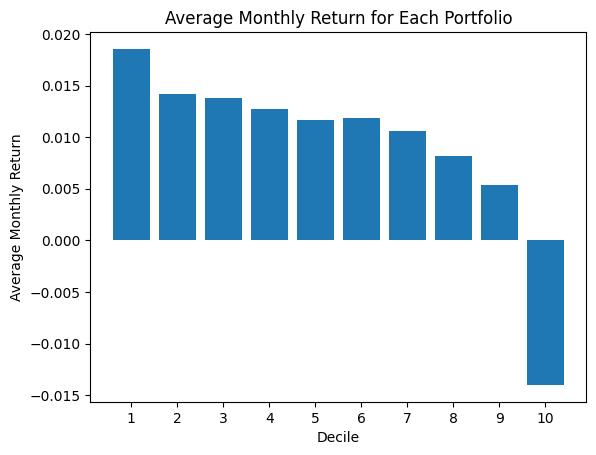

In [76]:
# Use a bar chart to illustrate average returns for the ten portfolios from Jan. 2010 to Dec. 2023.
plt.bar(decile_return_all["decile"], decile_return_all["monthly_return"])
plt.xlabel("Decile")
plt.ylabel("Average Monthly Return")
plt.title("Average Monthly Return for Each Portfolio")
plt.xticks(range(1, 11))

# Show and save the graph
plt.savefig(r"C:\Users\DELL\Desktop\Interview\Assignment_2\output\Portfolios_return.png", dpi = 300)
# plt.show()

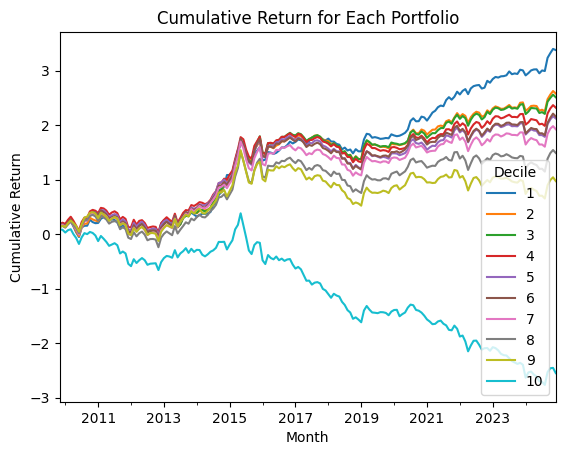

In [77]:
# Show cumulative returns for each decile portfolio from Jan. 2010 to Dec. 2023
# .cumsum(): calculates the cumulative sum.
decile_return["cumulative_return"] = decile_return.groupby("decile")["monthly_return"].cumsum()

# pivot(): reshape your df into a more analysis-friendly (and plotting-friendly) format.
# pivot(index = ..., columns = ..., values = ...):
# Each row corresponds to a unique value in the index column
# Each column corresponds to a unique value in the columns column
# Each cell corresponds to a unique value in the values column
decile_return = decile_return.pivot(index = "month", columns = "decile", values = "cumulative_return")

decile_return.plot()
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return for Each Portfolio")
plt.legend(title = "Decile")
